In [68]:
import pandas as pd
import boto3, re, sys, math, json, os, sagemaker, urllib.request
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import boto3
import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
region = boto3.session.Session().region_name
from sagemaker.serializers import CSVSerializer

In [ ]:
df = pd.read_csv('s3://myprojectbucket123/train/used_cars.csv')
df.head()

In [4]:
new_df = df[['manufacturer_name','model_name','transmission','color','odometer_value','year_produced','engine_fuel','engine_type','drivetrain','price_usd']]

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
new_df['odometer_value'] = scaler.fit_transform(new_df['odometer_value'].values.reshape(-1,1))
new_df['year_produced'] = scaler.fit_transform(new_df['year_produced'].values.reshape(-1,1))
labelencode = LabelEncoder()
new_df['manufacturer_name'] = labelencode.fit_transform(new_df['manufacturer_name'].values.reshape(-1,1))
new_df['model_name'] = labelencode.fit_transform(new_df['model_name'].values.reshape(-1,1))
new_df['color'] = labelencode.fit_transform(new_df['color'].values.reshape(-1,1))


new_df = pd.get_dummies(new_df, columns = ['transmission','engine_fuel','engine_type','drivetrain']) 
new_df.head()

/tmp/ipykernel_254/2192248105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['odometer_value'] = scaler.fit_transform(new_df['odometer_value'].values.reshape(-1,1))
/tmp/ipykernel_254/2192248105.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['year_produced'] = scaler.fit_transform(new_df['year_produced'].values.reshape(-1,1))
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

,manufacturer_name,model_name,color,odometer_value,year_produced,price_usd,transmission_automatic,transmission_mechanical,engine_fuel_diesel,engine_fuel_electric,engine_fuel_gas,engine_fuel_gasoline,engine_fuel_hybrid-diesel,engine_fuel_hybrid-petrol,engine_type_diesel,engine_type_electric,engine_type_gasoline,drivetrain_all,drivetrain_front,drivetrain_rear
0,45,764,8,-0.432604,0.874857,10900.00,1,0,0,0,0,1,0,0,0,0,1,1,0,0
1,45,764,1,0.302309,-0.117007,5000.00,1,0,0,0,0,1,0,0,0,0,1,1,0,0
2,45,519,7,1.125411,-0.240990,2800.00,1,0,0,0,0,1,0,0,0,0,1,1,0,0
3,45,609,1,-1.755446,-0.488956,9999.00,0,1,0,0,0,1,0,0,0,0,1,1,0,0
4,45,665,0,0.228818,-0.240990,2134.11,1,0,0,0,0,1,0,0,0,0,1,1,0,0


In [6]:
#just to make it simplified, we are taking main features into consideration


x_train, x_test, y_train,y_test = train_test_split(new_df.drop(columns = ['price_usd'],axis = 1),new_df.price_usd.values,test_size=0.2, random_state=42)
print(new_df.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(38531, 20)
(30824, 19)
(7707, 19)
(30824,)


In [7]:
rf = RandomForestRegressor(random_state=0)
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=0)

In [9]:
features = list(x_train.columns)

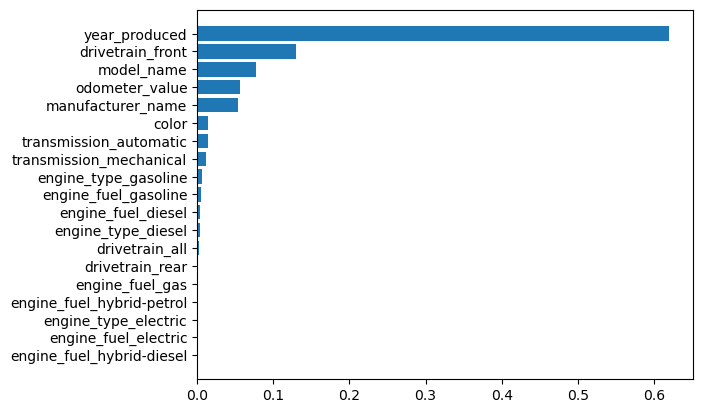

In [10]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [11]:
#as drivetrain is not that important, removing the feature from final model
#As some of the transmission, engine type and engine fuel are important, we are keeping those features as an input from the user

In [16]:
train_data, test_data = np.split(new_df.sample(frac=1, random_state=1729), [int(0.7 * len(new_df))])
print(train_data.shape, test_data.shape)

(26971, 20) (11560, 20)


In [17]:
train_data.drop(columns = ['drivetrain_all','drivetrain_front'],axis = 1, inplace = True)
test_data.drop(columns = ['drivetrain_all','drivetrain_front'],axis = 1, inplace = True)

In [18]:
train_data.shape

(26971, 18)

In [19]:
train_data.columns

Index(['manufacturer_name', 'model_name', 'color', 'odometer_value',
       'year_produced', 'price_usd', 'transmission_automatic',
       'transmission_mechanical', 'engine_fuel_diesel', 'engine_fuel_electric',
       'engine_fuel_gas', 'engine_fuel_gasoline', 'engine_fuel_hybrid-diesel',
       'engine_fuel_hybrid-petrol', 'engine_type_diesel',
       'engine_type_electric', 'engine_type_gasoline', 'drivetrain_rear'],
      dtype='object')

In [71]:
train_data = train_data[['price_usd','manufacturer_name', 'model_name', 'color', 'odometer_value',
       'year_produced',  'transmission_automatic',
       'transmission_mechanical', 'engine_fuel_diesel', 'engine_fuel_electric',
       'engine_fuel_gas', 'engine_fuel_gasoline', 'engine_fuel_hybrid-diesel',
       'engine_fuel_hybrid-petrol', 'engine_type_diesel',
       'engine_type_electric', 'engine_type_gasoline']]
test_data = test_data[['price_usd','manufacturer_name', 'model_name', 'color', 'odometer_value',
       'year_produced',  'transmission_automatic',
       'transmission_mechanical', 'engine_fuel_diesel', 'engine_fuel_electric',
       'engine_fuel_gas', 'engine_fuel_gasoline', 'engine_fuel_hybrid-diesel',
       'engine_fuel_hybrid-petrol', 'engine_type_diesel',
       'engine_type_electric', 'engine_type_gasoline']]

In [72]:
train_data.to_csv('s3://myprojectbucket123/train/train.csv', index=False, header=False)

In [73]:
prefix = 'train'
bucket_name = 'myprojectbucket123'

In [74]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [75]:
train_data.columns

Index(['price_usd', 'manufacturer_name', 'model_name', 'color',
       'odometer_value', 'year_produced', 'transmission_automatic',
       'transmission_mechanical', 'engine_fuel_diesel', 'engine_fuel_electric',
       'engine_fuel_gas', 'engine_fuel_gasoline', 'engine_fuel_hybrid-diesel',
       'engine_fuel_hybrid-petrol', 'engine_type_diesel',
       'engine_type_electric', 'engine_type_gasoline'],
      dtype='object')

In [76]:
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "verbosity":"1",
        "objective":"reg:squarederror",
        "num_round":"50"}
output_path = 's3://myprojectbucket123/output/'

In [77]:
a = train_data.to_numpy()
b = test_data.to_numpy()

In [79]:
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

model = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

model.fit({'train': s3_input_train})

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-28-04-39-37-954


2023-11-28 04:39:38 Starting - Starting the training job...
2023-11-28 04:39:54 Starting - Preparing the instances for training.........
2023-11-28 04:41:21 Downloading - Downloading input data...
2023-11-28 04:41:46 Training - Downloading the training image...
2023-11-28 04:42:12 Training - Training image download completed. Training in progress..[2023-11-28 04:42:35.727 ip-10-0-195-123.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-11-28 04:42:35.750 ip-10-0-195-123.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-11-28:04:42:36:INFO] Imported framework sagemaker_xgboost_container.training
[2023-11-28:04:42:36:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2023-11-28:04:42:36:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-28:04:42:36:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-11-28:04:42:36:INFO] Determined 0 GPU(s) available on the i

In [85]:
xgb_predictor = model.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-28-04-49-31-935
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-28-04-49-31-935
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-28-04-49-31-935


------!

In [110]:
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = CSVSerializer() # set the serializer type

In [111]:
#model prediction On train data

In [112]:
train_data_array = train_data.drop(['price_usd'], axis=1).values
predictions_train = xgb_predictor.predict(train_data_array).decode('utf-8') # predict!
predictions_array_train = np.fromstring(predictions_train, sep='\n') # and turn the prediction into an array
print(predictions_array_train.shape)
predictions_array_train

(26971,)


array([ 2595.22290039,  8118.34960938,  5592.2109375 , ...,
        6068.73681641,  5138.44091797, 11211.09960938])

In [113]:
from sklearn.metrics import r2_score
print("R2 score : %.2f" % r2_score(train_data['price_usd'],predictions_array_train))

R2 score : 0.87


In [114]:
#Model prediction on tet data

In [115]:
test_data_array = test_data.drop(['price_usd'], axis=1).values

In [116]:
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions, sep='\n') # and turn the prediction into an array
print(predictions_array.shape)
predictions_array

(11560,)


array([ 1226.18310547,  5977.69091797,  2212.28173828, ...,
       14047.00292969,  1523.02514648, 15446.75097656])

In [117]:
from sklearn.metrics import r2_score
print("R2 score : %.2f" % r2_score(test_data['price_usd'],predictions_array))

R2 score : 0.86
